# Nepali Text Sentiment Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import re

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Move 3 levels up to the project root directory and append to sys.path
project_root = os.path.abspath(os.path.join(current_dir, '../../'))
sys.path.append(project_root)

In [4]:
DATASET_PATH = os.path.join(
    project_root,
    'nepali_sentiment_analysis',
    'dataset',
    'processed',
    'combined_cleaned_data.csv'
)

df = pd.read_csv(DATASET_PATH)

In [5]:
df.head()

,Sentiment,Sentences
0,0,पुन निर्वाचन गरे यस्तै हुने हो
1,0,निर्वाचन कति गरिरहने
2,0,शासन व्यवस्था चुनाव पध्दति फेर्नु एउटा उपचार हो
3,0,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे
4,0,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...


In [6]:
print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())


Sentiment Distribution:
Sentiment
1    15951
2    14422
0    13263
Name: count, dtype: int64


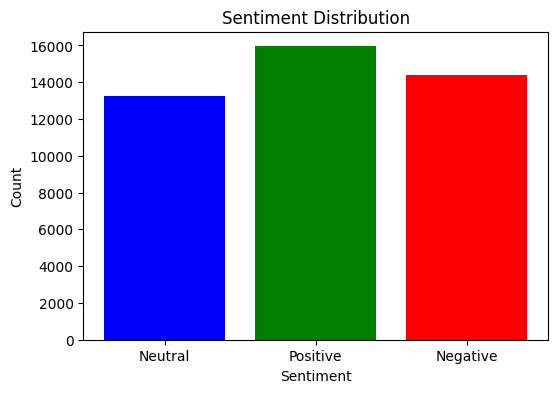

In [7]:
from nepali_sentiment_analysis.utils import visualization

labels_dict = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

visualization.plot_sentiment_distribution(
    df, 'Sentiment Distribution', labels_dict
)

---

In [8]:
from utils.preprocess import preprocess

In [9]:
# Apply preprocessing to all sentences
tqdm.pandas()
df["Processed_Sentences"] = df["Sentences"].progress_apply(lambda x: preprocess(x)[0])

100%|██████████| 43636/43636 [00:01<00:00, 37122.16it/s]


In [10]:
# Display preprocessed text
print("\nSample Preprocessed Text:")
df.sample(5)


Sample Preprocessed Text:


,Sentiment,Sentences,Processed_Sentences
43382,0,ईटहरी तिर कहिले आईपुग्ने हो,ईटहरी कहिले आईपुग्ने हो
39002,1,कोभिड कञ्चनपुरमा सेनाको सेवा सराहनीय,कोभिड कञ्चनपुरमा सेनाको सेवा सराहनीय
15866,1,मौसम फेरीय जसरी फेरीने का भनाई हरूले कोरोना को...,मौसम फेरीय जसरी फेरीने भनाई हरूले कोरोना कोभिड...
34593,2,सरकारको चौथो अङ्ग सञ्चार माध्यमले कोभिड बारे ज...,सरकारको चौथो अङ्ग सञ्चार माध्यमले कोभिड बारे ज...
6844,0,सुझावको लागि,सुझावको लागि


In [11]:
df.iloc[1]['Sentences']

'निर्वाचन कति गरिरहने'

In [12]:
from utils.embedding import Embeddings

In [13]:
# Load pretrained word2vec embeddings
embedding_path = "models/nepali_embeddings_word2vec.kv"
word_vectors = Embeddings().load_vector()

# Define embedding dimension
embedding_dim = word_vectors.vector_size
print(f"Loaded embeddings with dimension: {embedding_dim}")

Loaded embeddings with dimension: 300


In [14]:
# Tokenize and convert sentences to embeddings
max_length = 32  # Maximum number of tokens per sentence


def sentence_to_embedding(sentence):
    tokens = sentence.split()
    embeddings = [
        word_vectors[token] if token in word_vectors else np.zeros(
            embedding_dim)
        for token in tokens
    ]
    # Padding/truncating to max_length
    if len(embeddings) > max_length:
        embeddings = embeddings[:max_length]
    else:
        embeddings += [np.zeros(embedding_dim)] * \
            (max_length - len(embeddings))
    return np.array(embeddings)


# Apply to all processed sentences
embedded_sentences = np.array(
    df["Processed_Sentences"].apply(sentence_to_embedding).tolist())
sentiments = df["Sentiment"].values

print(f"Embedded Sentences Shape: {embedded_sentences.shape}")

Embedded Sentences Shape: (43636, 32, 300)


In [15]:
import math

In [16]:
# %%
class SentimentTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, num_classes, d_ff, max_len, dropout):
        super(SentimentTransformer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout)
             for _ in range(num_layers)]
        )
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

# Helper classes for positional encoding and encoder layers


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2)
                             * (math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.feed_forward(x))
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        bs = q.size(0)
        q = self.q_linear(q).view(bs, -1, self.num_heads,
                                  self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(bs, -1, self.num_heads,
                                  self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(bs, -1, self.num_heads,
                                  self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, v).transpose(
            1, 2).contiguous().view(bs, -1, self.num_heads * self.d_k)
        return self.out(output)

In [17]:
# %%
# Convert data to tensors
embedded_sentences_tensor = torch.tensor(
    embedded_sentences, dtype=torch.float32)
sentiments_tensor = torch.tensor(sentiments, dtype=torch.long)

# Create dataset and split
dataset = TensorDataset(embedded_sentences_tensor, sentiments_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for batch processing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print dataset sizes
print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")

Training Set Size: 34908
Validation Set Size: 8728


In [18]:
# %%
# Model parameters
d_model = embedding_dim  # Embedding dimension
num_heads = 4  # Number of attention heads
num_layers = 2  # Number of encoder layers
num_classes = 3  # Neutral, Positive, Negative
d_ff = 128  # Dimension of feedforward network
dropout = 0.1  # Dropout rate
max_len = max_length

# Instantiate the model
model = SentimentTransformer(
    d_model, num_heads, num_layers, num_classes, d_ff, max_len, dropout).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

SentimentTransformer(
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (q_linear): Linear(in_features=300, out_features=300, bias=True)
        (k_linear): Linear(in_features=300, out_features=300, bias=True)
        (v_linear): Linear(in_features=300, out_features=300, bias=True)
        (out): Linear(in_features=300, out_features=300, bias=True)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=300, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=300, out_features=3, bias=True)
)


---

## Training

Train the model over multiple epochs, tracking loss and accuracy.

In [19]:
# %%
# Training loop
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_predictions / len(val_loader.dataset)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {
          val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Train Loss: 0.7569, Validation Loss: 0.7161, Validation Accuracy: 0.6955
Epoch 2/50, Train Loss: 0.7273, Validation Loss: 0.7169, Validation Accuracy: 0.6853
Epoch 3/50, Train Loss: 0.7265, Validation Loss: 0.7237, Validation Accuracy: 0.6895
Epoch 4/50, Train Loss: 0.7129, Validation Loss: 0.7236, Validation Accuracy: 0.6852
Epoch 5/50, Train Loss: 0.7137, Validation Loss: 0.7137, Validation Accuracy: 0.6911
Epoch 6/50, Train Loss: 0.7069, Validation Loss: 0.7149, Validation Accuracy: 0.6915
Epoch 7/50, Train Loss: 0.6958, Validation Loss: 0.7219, Validation Accuracy: 0.6921
Epoch 8/50, Train Loss: 0.7012, Validation Loss: 0.7212, Validation Accuracy: 0.6912
Epoch 9/50, Train Loss: 0.6965, Validation Loss: 0.7093, Validation Accuracy: 0.6940
Epoch 10/50, Train Loss: 0.7004, Validation Loss: 0.7082, Validation Accuracy: 0.6956
Epoch 11/50, Train Loss: 0.6965, Validation Loss: 0.7242, Validation Accuracy: 0.6913
Epoch 12/50, Train Loss: 0.6905, Validation Loss: 0.7081, Valid

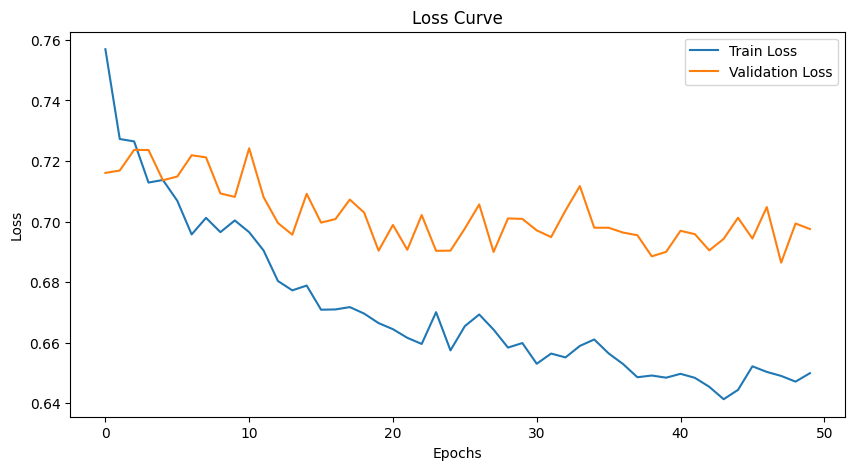

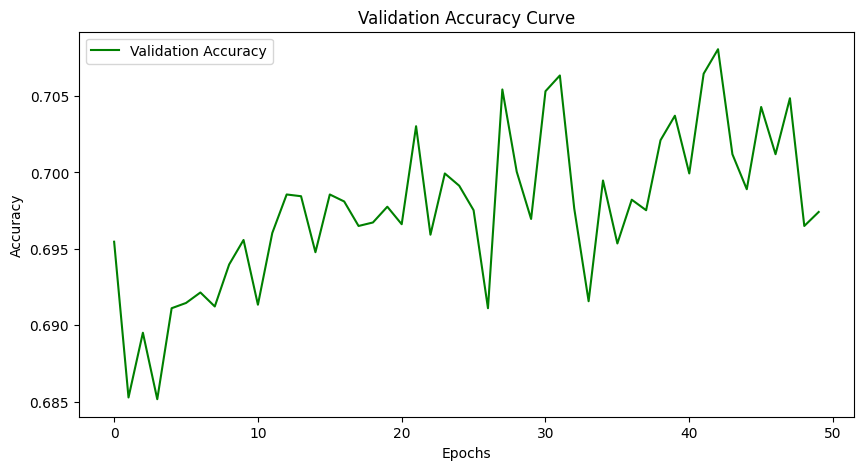

In [20]:
# %%
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# %%
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.title("Validation Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

F1 Score: 0.6973
Precision: 0.6976
Recall: 0.6974

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.70      0.69      0.70      2559
    Positive       0.70      0.68      0.69      3176
    Negative       0.69      0.72      0.71      2993

    accuracy                           0.70      8728
   macro avg       0.70      0.70      0.70      8728
weighted avg       0.70      0.70      0.70      8728



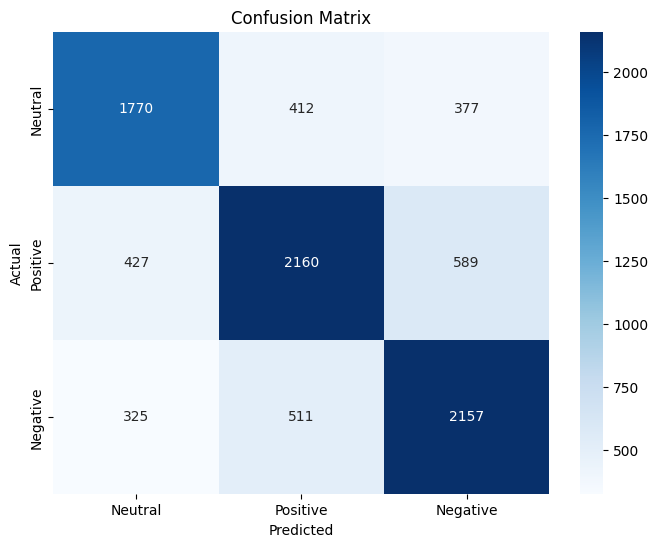

In [21]:
# %%
# Evaluate model on validation set
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(actuals, predictions, average="weighted")
precision = precision_score(actuals, predictions, average="weighted")
recall = recall_score(actuals, predictions, average="weighted")
conf_matrix = confusion_matrix(actuals, predictions)

# Display metrics
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(actuals, predictions,
      target_names=["Neutral", "Positive", "Negative"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
            "Neutral", "Positive", "Negative"], yticklabels=["Neutral", "Positive", "Negative"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

---

## Saving the Model

In [22]:
# Get the current path and go one step up
current_path = os.path.abspath(os.path.join(current_dir, '..'))

# Check if 'models' directory exists, if not, create it
models_dir = os.path.join(current_path, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model_save_path = os.path.join(models_dir, "sentiment_transformer_model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to c:\Users\Suyash Shrestha\Personal\_Nepali_news_project\Nepali_News_algorithms\news_algorithms\nepali_sentiment_analysis\models\sentiment_transformer_model.pth


---

## Loading the Model

In [23]:
# Load the model for inference
loaded_model = SentimentTransformer(
    d_model,
    num_heads,
    num_layers,
    num_classes,
    d_ff,
    max_len,
    dropout
)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
loaded_model.eval()
print("Model loaded successfully for inference!")

Model loaded successfully for inference!


C:\Users\Suyash Shrestha\AppData\Local\Temp\ipykernel_10548\3791078217.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_sav

In [24]:
# Sample sentences for inference
sentences = [
    "म आजको खाना खान गरें।",
    "मलाई यो गाउँ मन पर्छ।",
    "म यो गाडी नचलाउन चाहन्छु"
]

In [25]:
# Preprocess and tokenize sentences
processed_sentences = [preprocess(sentence)[0] for sentence in sentences]
embedded_sentences = np.array(
    [sentence_to_embedding(sentence) for sentence in processed_sentences])

In [26]:
# Convert to tensor
embedded_sentences_tensor = torch.tensor(
    embedded_sentences,
    dtype=torch.float32
).to(device)

In [27]:
# Perform inference
predictions = []

with torch.no_grad():
    for inputs in embedded_sentences_tensor:
        inputs = inputs.unsqueeze(0)
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.item())

In [28]:
# Display predictions
for sentence, prediction in zip(sentences, predictions):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {labels_dict[prediction]}\n")

Sentence: म आजको खाना खान गरें।
Predicted Sentiment: Neutral

Sentence: मलाई यो गाउँ मन पर्छ।
Predicted Sentiment: Neutral

Sentence: म यो गाडी नचलाउन चाहन्छु
Predicted Sentiment: Neutral



In [29]:
text = "म खुसी छु"
processed_text = preprocess(text)[0]
embedded_text = sentence_to_embedding(processed_text)
embedded_text_tensor = torch.tensor(
    embedded_text,
    dtype=torch.float32
).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    outputs = loaded_model(embedded_text_tensor)
    _, predicted = torch.max(outputs, 1)

# Display prediction
print(f"Text: {text}")
print(f"Predicted Sentiment: {labels_dict[predicted.item()]}")

Text: म खुसी छु
Predicted Sentiment: Positive


In [32]:
neg = "म खुशी छैन"
processed_text = preprocess(neg)[0]
embedded_text = sentence_to_embedding(processed_text)
embedded_text_tensor = torch.tensor(
    embedded_text,
    dtype=torch.float32
).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    outputs = loaded_model(embedded_text_tensor)
    _, predicted = torch.max(outputs, 1)

# Display prediction
print(f"Text: {neg}")
print(f"Predicted Sentiment: {labels_dict[predicted.item()]}")

Text: म खुशी छैन
Predicted Sentiment: Negative


In [34]:
def predict_sentiment(text):
    processed_text = preprocess(text)[0]
    embedded_text = sentence_to_embedding(processed_text)
    embedded_text_tensor = torch.tensor(
        embedded_text,
        dtype=torch.float32
    ).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = loaded_model(embedded_text_tensor)
        _, predicted = torch.max(outputs, 1)

    return labels_dict[predicted.item()]

In [35]:
# Test the function
test_text = "म दुखी छु"
predicted_sentiment = predict_sentiment(test_text)
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Text: म दुखी छु
Predicted Sentiment: Negative


In [36]:
test_text = "म मर्न चाहन्छु"
predicted_sentiment = predict_sentiment(test_text)
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Text: म मर्न चाहन्छु
Predicted Sentiment: Neutral
